In [4]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import os
#import matplotlib as mpl
#import matplotlib.pyplot as plt
from global_land_mask import globe
import dask
import dask.array as da


def haversine_distance(lat, lon):
    """
    Calculate pairwise distances between points using Haversine formula.

    Parameters:
    - lat (ndarray) : 1-d flattened latitude grid
    - lon (ndarray) : 1-d flattened longitude grid
    Returns:
    - distances (ndarray): Pairwise distances matrix.
    """

    # Earth radius in kilometers
    earth_radius = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat_rad = da.radians(lat)
    lon_rad = da.radians(lon)

    # Compute differences in latitude and longitude
    dlat = lat_rad[:, np.newaxis] - lat_rad
    dlon = lon_rad[:, np.newaxis] - lon_rad

    # Haversine formula
    a = da.sin(dlat / 2.0) ** 2 + da.cos(lat_rad) * da.cos(lat_rad[:, np.newaxis]) * da.sin(dlon / 2.0) ** 2
    c = 2 * da.arctan2(da.sqrt(a), da.sqrt(1 - a))

    # Calculate pairwise distances in kilometers
    distances = earth_radius * c

    return distances

def haversine_blockwise(lat1, lon1, lat2, lon2):
    """
    Calculate a block of a Haversine pairwise distance matrix.
    For blocks on the diagonal lat1=lat2, lon1 = lon2.

    Parameters:
    - lat1 (ndarray) : 1-d flattened latitude grid
    - lon1 (ndarray) : 1-d flattened longitude grid
    - lat2 (ndarray) : 1-d flattened latitude grid
    - lon2 (ndarray) : 1-d flattened longitude grid
    Returns:
    - distances (ndarray): Pairwise distances matrix.
    """
    # Earth radius in kilometers
    earth_radius = 6371.0
    lat1, lat2, lon1, lon2 = map(np.radians, [lat1, lat2, lon1, lon2])
    dlat = lat1[:, np.newaxis] - lat2
    dlon = lon1[:, np.newaxis] - lon2
    a = da.sin(dlat / 2.0) ** 2 + da.cos(lat2) * da.cos(lat1[:, np.newaxis]) * da.sin(dlon / 2.0) ** 2
    c = 2 * da.arctan2(da.sqrt(a), da.sqrt(1 - a))

    # Calculate pairwise distances in kilometers
    distances = earth_radius * c

    return distances




def haversine_np(lat1, lat2, lon1, lon2):
    """
    from: Daniel F https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    
    All args must be of equal length. 
       
    
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6378.137 * c
    return km

def create_lsm(latmin, latmax, lonmin, lonmax):
     """Creates a land-sea mask (land=1, sea=0) in 0.1 deg x 0.1 deg resolution
     for the chosen area.
     """
     lat = np.linspace(latmin,latmax, (latmax-latmin)*10+1)#, dtype=np.float32)
     lon = np.linspace(lonmin,lonmax, (lonmax - lonmin)*10+1)#, dtype=np.float32)
     longrid, latgrid = np.meshgrid(lon,lat)
     lsm = globe.is_land(latgrid, longrid)
   
     return lsm, latgrid, longrid

def pick_coords(lsm, latgrid, longrid, v, nchunks = 2):
    if v == "land":
        latv = latgrid[lsm].flatten()
        lonv = longrid[lsm].flatten()
        
                         
    elif v == "ocean":
        latv = latgrid[~lsm].flatten()
        lonv = longrid[~lsm].flatten()
    
    n = len(latv)

    latv = da.from_array(latv, chunks = int((n+1)/nchunks))
    lonv = da.from_array(lonv, chunks= int((n+1)/nchunks))
    
    return latv, lonv    

def compute_cov_blockwise(dists, L, sigmas, v):
    sigma = sigmas[v]
    l = L[v]    
    covv = sigma**2*da.exp(-1*dists/l)
    return covv




# def compute_cov_dask(lsm, latgrid, longrid, sigmas, L, v):
#     if v == "land":
#         latv = latgrid[lsm].flatten()
#         lonv = longrid[lsm].flatten()
        
             
            
#     elif v == "ocean":
#         latv = latgrid[~lsm].flatten()
#         lonv = longrid[~lsm].flatten()     

#     latv = da.from_array(latv)
#     lonv = da.from_array(lonv)
#     covv = da.empty((len(latv), len(latv)))       
#     sigma = sigmas[v]
#     l = L[v]
#     covv[:,:] = sigma**2*da.exp(-1*haversine_distance_dask(latv, lonv)/l)

#     return covv, latv, lonv
        
             

 
def create_dataset(covv, latv, lonv, v):
    
    """
    Creates an xarray dataset of the covariance matrix and coordinates of the grid.
    """
    out_cov = xr.Dataset(
    data_vars={"covariance": (["dim0", "dim1"], covv),
               "lon": (lonv),
                "lat": (latv),},
    attrs={'comment': f"Prior covariance matrix of CO2 {v} fluxes"})
    return out_cov
    




In [2]:
from dask.distributed import Client
client = Client(n_workers = 4, threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:41829' processes=4 threads=4, memory=30.78 GiB>

In [2]:
lat = [50, 52, 58]
lon = [0, 20, 30]
dists = haversine_distance(lat, lon)
dists

array([[   0.        , 1412.45760047, 2129.96736694],
       [1412.45760047,    0.        ,  921.16755204],
       [2129.96736694,  921.16755204,    0.        ]])

In [5]:
#Europe
latmin = 30
latmax = 75
lonmin = -15
lonmax = 40

#smaller testarea
# latmin = 30
# latmax = 50
# lonmin = -10
# lonmax = 0

# Uncertainty (std)
sigmas = {'land': 0.8,
          'ocean': 1.2} 


# Correlation length (km)
L = {'land': 100,  # 
     'ocean': 500}  # for ocean

v = "land"

today = datetime.now()
#output_filename = f'test_{v}_{today.strftime("%d%m%Y")}.nc'
OUTPUT_PATH = '/home/pietaril/Documents/data/unc_cov_matrices'


In [6]:
lsm, latgrid, longrid = create_lsm(latmin, latmax, lonmin, lonmax)
latv, lonv = pick_coords(lsm, latgrid, longrid, v, nchunks=1)
latv = latv[:100]
lonv = lonv[:100]
nb = latv.blocks[0].shape[0]
covv = da.empty((len(latv), len(latv)), chunks = (nb, nb))
dists =  da.empty((len(latv), len(latv)), chunks = (nb, nb))
#trying out the blockwise function but for the whole matrix
dists[:,:] = haversine_blockwise(latv, lonv, latv, lonv)
covv[:,:] = compute_cov_blockwise(dists, L, sigmas, v)
#ds = xr.DataArray(covv)
#w = ds.to_netcdf(os.path.join(OUTPUT_PATH, output_filename), compute=False)
#w.compute()

#dummy.to_netcdf()
#out = xr.DataArray(dummy, coords = [da.from_array(np.arange(len(latv)), chunks=nb), da.from_array(np.arange(len(latv)), chunks=nb)], dims= ["row", "col"])
# out = xr.Dataset(
#     data_vars={'covariance':(('dim0', 'dim1'), dummy),
#                "lon": ('dim0', lonv),
#                 "lat": ('dim0', latv),},
#     coords={'dim0': range(len(latv)),
#             'dim1': range(len(lonv))},)



In [8]:
covv.compute()[:5, :5]

array([[0.64      , 0.58124395, 0.52788209, 0.4794192 , 0.43540553],
       [0.58124395, 0.64      , 0.58124395, 0.52788209, 0.4794192 ],
       [0.52788209, 0.58124395, 0.64      , 0.58124395, 0.52788209],
       [0.4794192 , 0.52788209, 0.58124395, 0.64      , 0.58124395],
       [0.43540553, 0.4794192 , 0.52788209, 0.58124395, 0.64      ]])

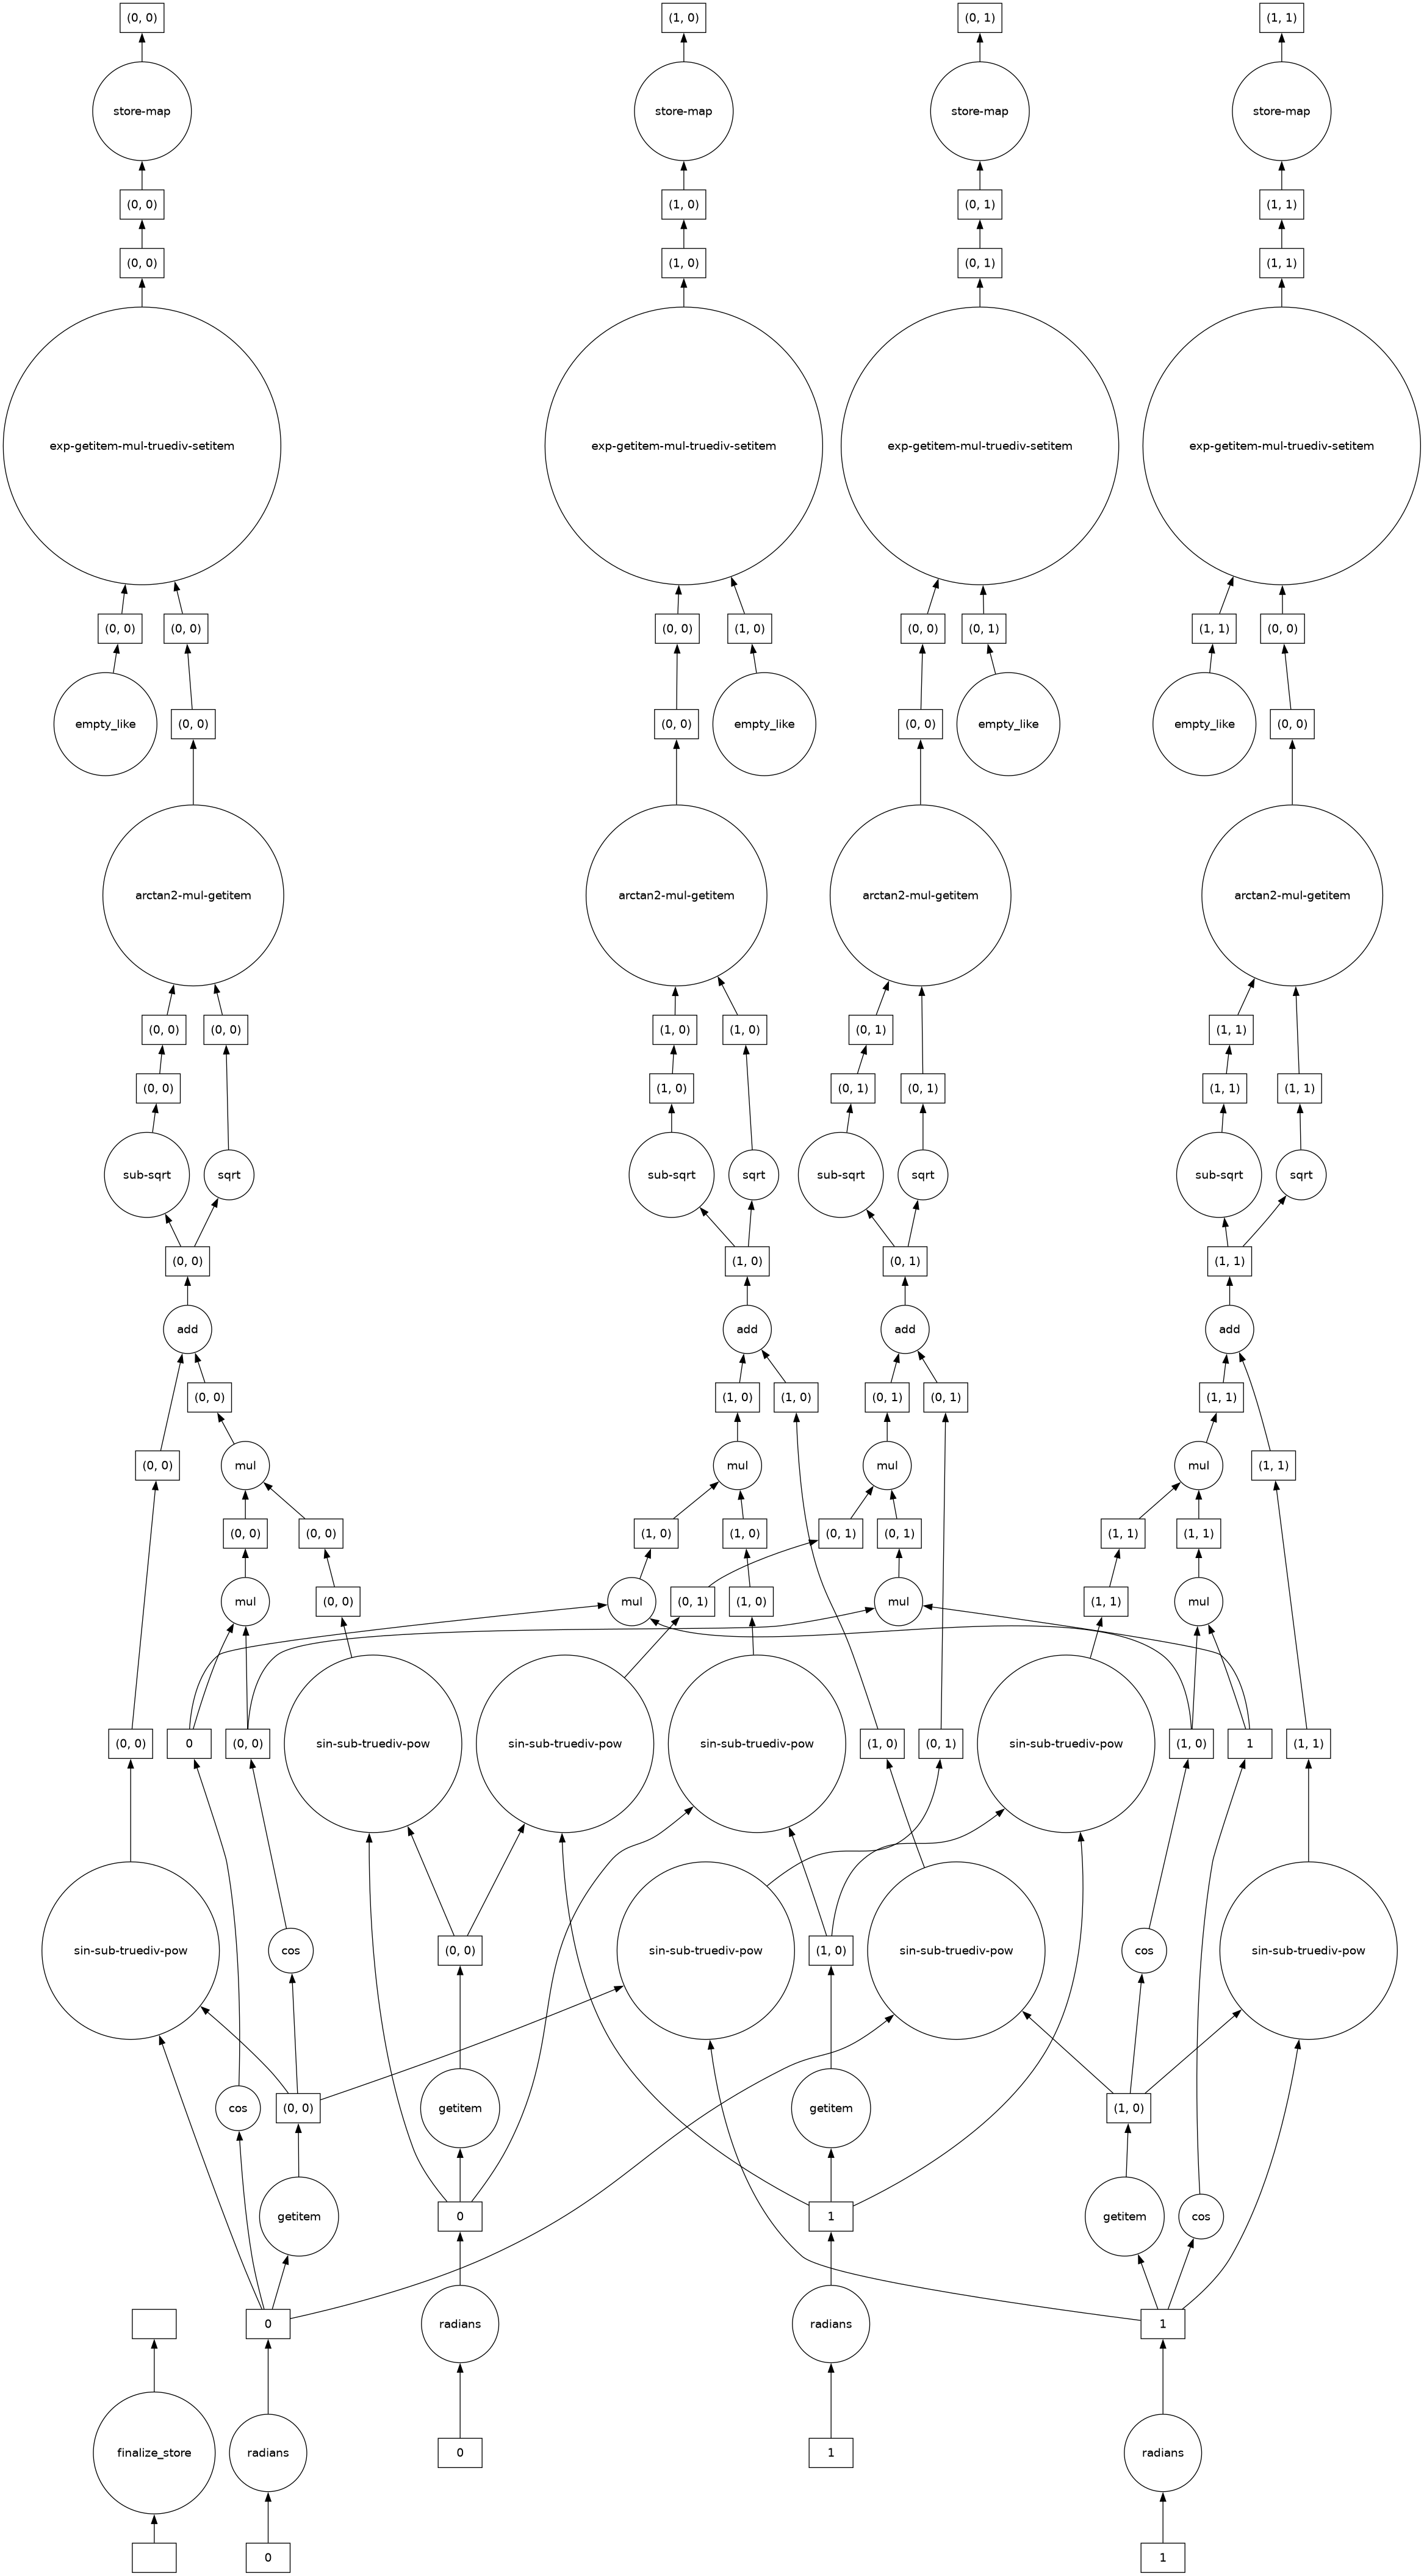

In [11]:
w.visualize()

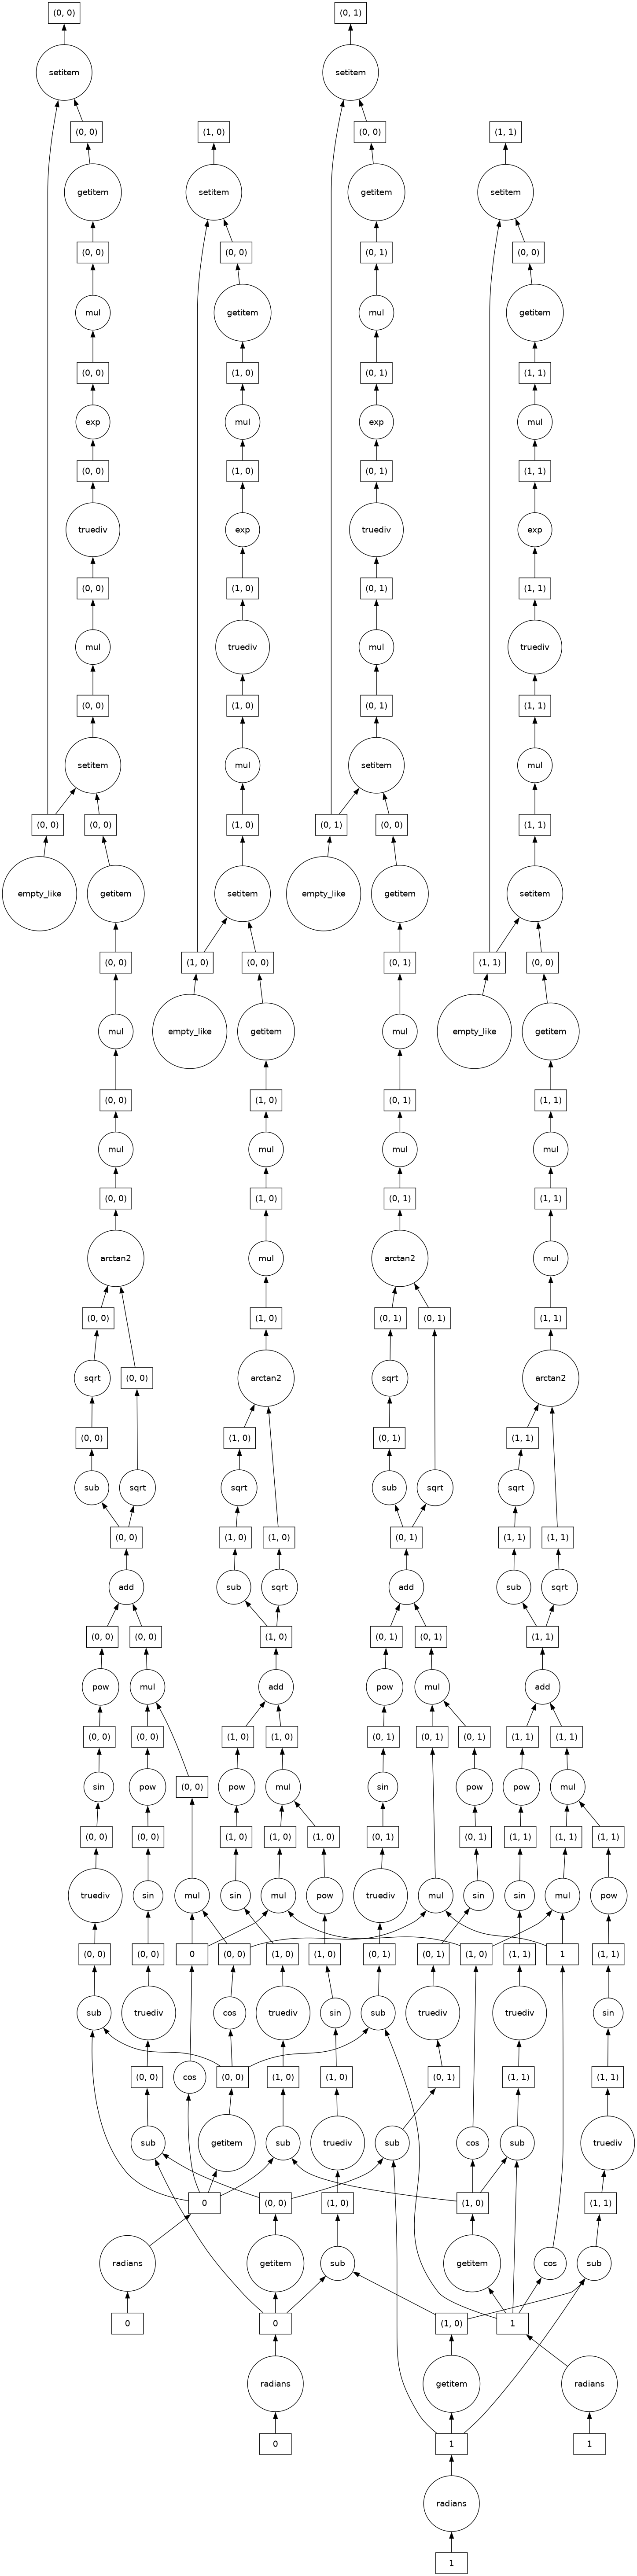

In [5]:
covv.visualize()

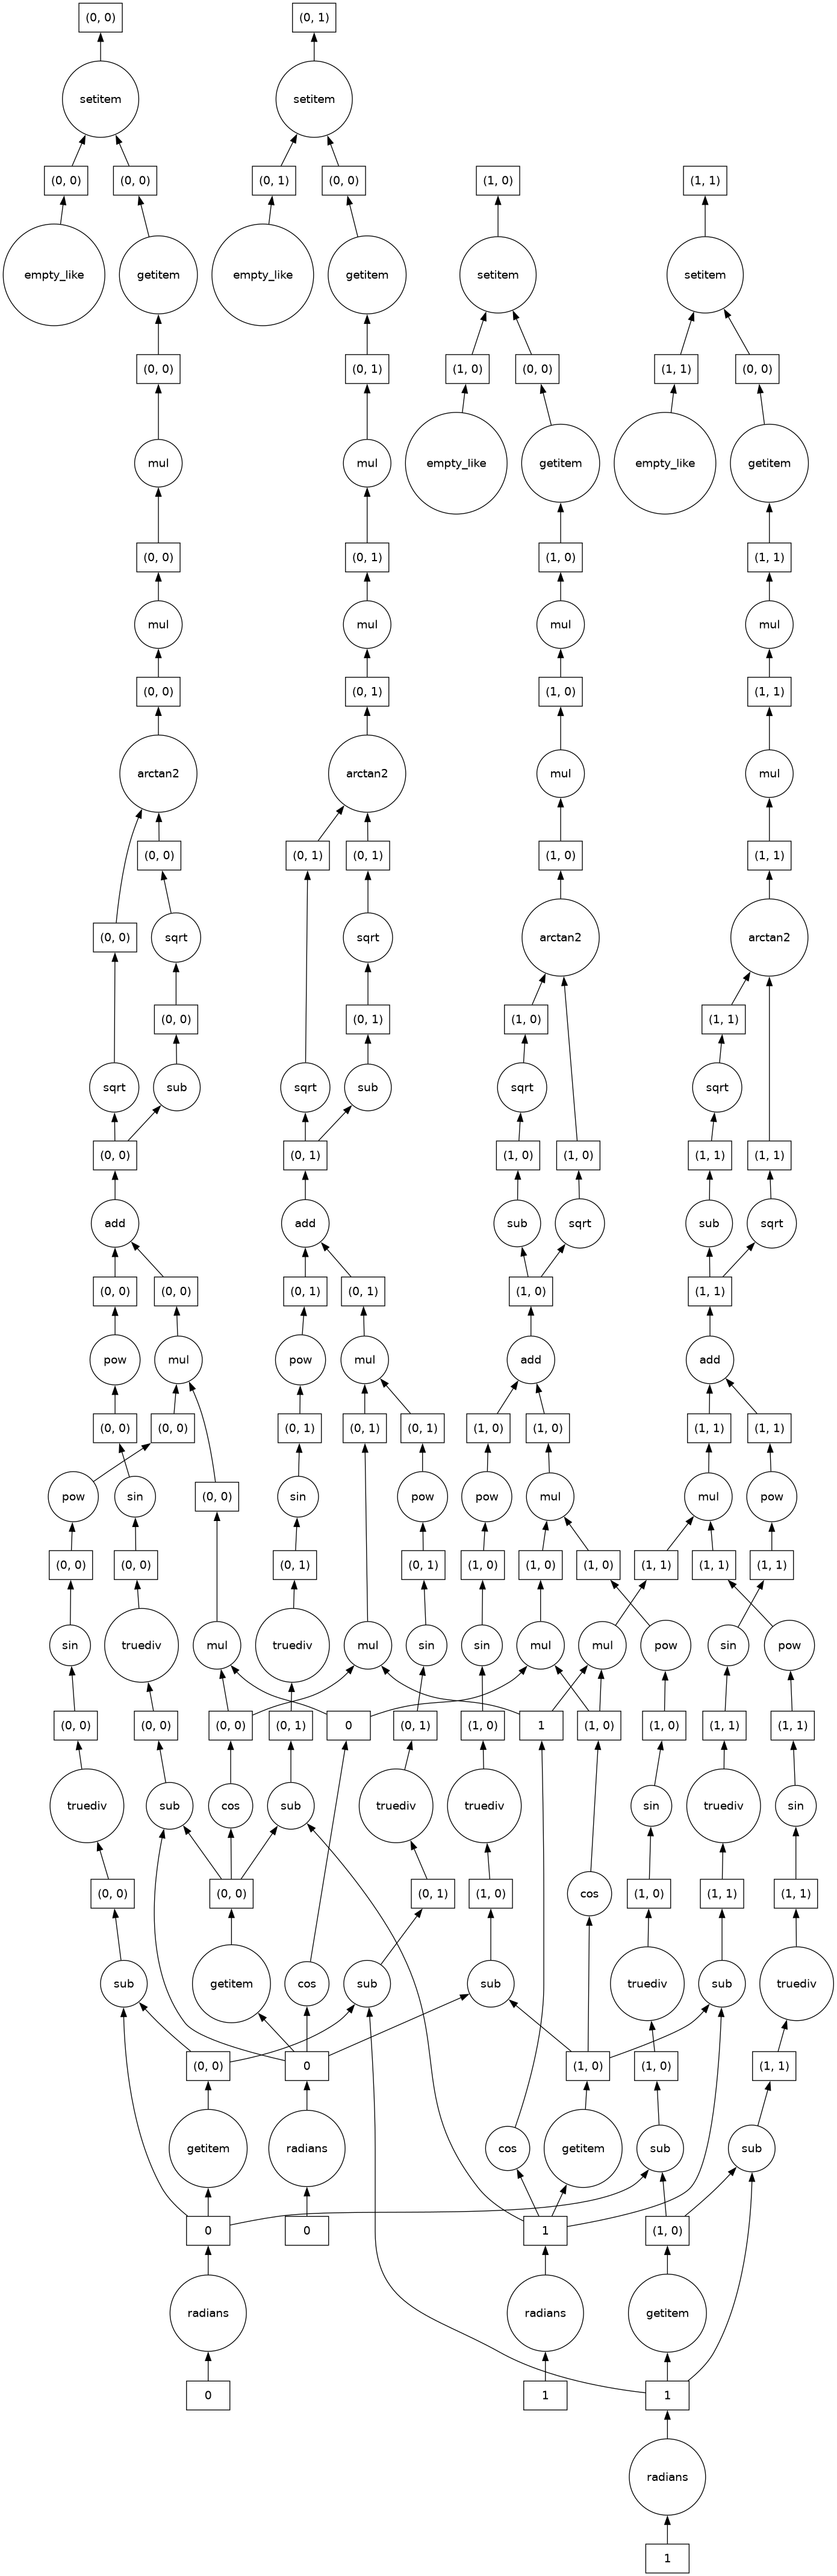

In [110]:
dummy.visualize()

In [106]:
dummy.blocks[0,0]

dask.array<blocks, shape=(5839, 5839), dtype=float64, chunksize=(5839, 5839), chunktype=numpy.ndarray>

In [105]:
out.to_delayed().ravel()

AttributeError: 'DataArray' object has no attribute 'to_delayed'

In [107]:
for ii in range(2):
    for jj in range(ii,2):
        dists = haversine_blockwise(latv.blocks[ii], lonv.blocks[ii], latv.blocks[jj], latv.blocks[jj])
        dummy.blocks[ii,jj] = compute_cov_blockwise(dists, L, sigmas, v)
        out.to_netcdf()
        
        
        

TypeError: 'BlockView' object does not support item assignment

In [71]:
latv.to_delayed().ravel()

array([Delayed(('array-b6e9b545ffd35ba022accfa3297d9c3c', 0)),
       Delayed(('array-b6e9b545ffd35ba022accfa3297d9c3c', 1))],
      dtype=object)

In [29]:
covv_chunks =  covv.to_delayed().ravel()
covv_chunks


array([Delayed(('setitem-f27964146cb3d4127e8a8d341408194b', 0, 0)),
       Delayed(('setitem-f27964146cb3d4127e8a8d341408194b', 0, 1)),
       Delayed(('setitem-f27964146cb3d4127e8a8d341408194b', 0, 2)),
       Delayed(('setitem-f27964146cb3d4127e8a8d341408194b', 1, 0)),
       Delayed(('setitem-f27964146cb3d4127e8a8d341408194b', 1, 1)),
       Delayed(('setitem-f27964146cb3d4127e8a8d341408194b', 1, 2)),
       Delayed(('setitem-f27964146cb3d4127e8a8d341408194b', 2, 0)),
       Delayed(('setitem-f27964146cb3d4127e8a8d341408194b', 2, 1)),
       Delayed(('setitem-f27964146cb3d4127e8a8d341408194b', 2, 2))],
      dtype=object)

In [21]:
today = datetime.now()
output_filename = f'test_{v}_{today.strftime("%d%m%Y")}.zarr'
OUTPUT_PATH = '/home/pietaril/Documents/data/unc_cov_matrices'
out.to_zarr(os.path.join(OUTPUT_PATH, output_filename), compute = False)

Delayed('_finalize_store-65b05f2c-ba1c-4c8f-96bb-c3f97b7075d0')

In [39]:
def write_blocks_to_zarr(data, filepath):
    data.to_zarr(filepath, compute = False)

In [40]:
ds = xr.Dataset({'covariance':(('dim0', 'dim1'), covv)})
fname = os.path.join(OUTPUT_PATH, output_filename)
outblocks = ds.map_blocks(write_blocks_to_zarr, args=[fname], template=out)

In [5]:
today = datetime.now()
output_filename = f'CO2_prior_cov_eur_{v}_{today.strftime("%d%m%Y")}.zarr'
OUTPUT_PATH = '/home/pietaril/Documents/data/unc_cov_matrices'
w = out_covv.to_zarr(os.path.join(OUTPUT_PATH, output_filename), compute = False)

In [8]:
w.compute()

In [13]:
ds = xr.open_zarr(os.path.join(OUTPUT_PATH, "CO2_prior_cov_test_land_28052024.zarr"))
ds


<xarray.Dataset>
Dimensions:     (dim0: 11678, dim1: 11678, lat: 11678, lon: 11678)
Coordinates:
  * lat         (lat) float64 30.0 30.0 30.0 30.0 30.0 ... 49.6 49.7 49.7 50.0
  * lon         (lon) float64 -9.7 -9.6 -9.5 -9.4 -9.3 ... -1.3 -1.9 -1.4 -5.2
Dimensions without coordinates: dim0, dim1
Data variables:
    covariance  (dim0, dim1) float64 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
Attributes:
    comment:  Prior covariance matrix of CO2 land fluxes

In [52]:
ds.covariance[0:10, 0:10].load

<bound method DataArray.load of <xarray.DataArray 'covariance' (dim0: 10, dim1: 10)>
dask.array<getitem, shape=(10, 10), dtype=float64, chunksize=(10, 10), chunktype=numpy.ndarray>
Dimensions without coordinates: dim0, dim1>

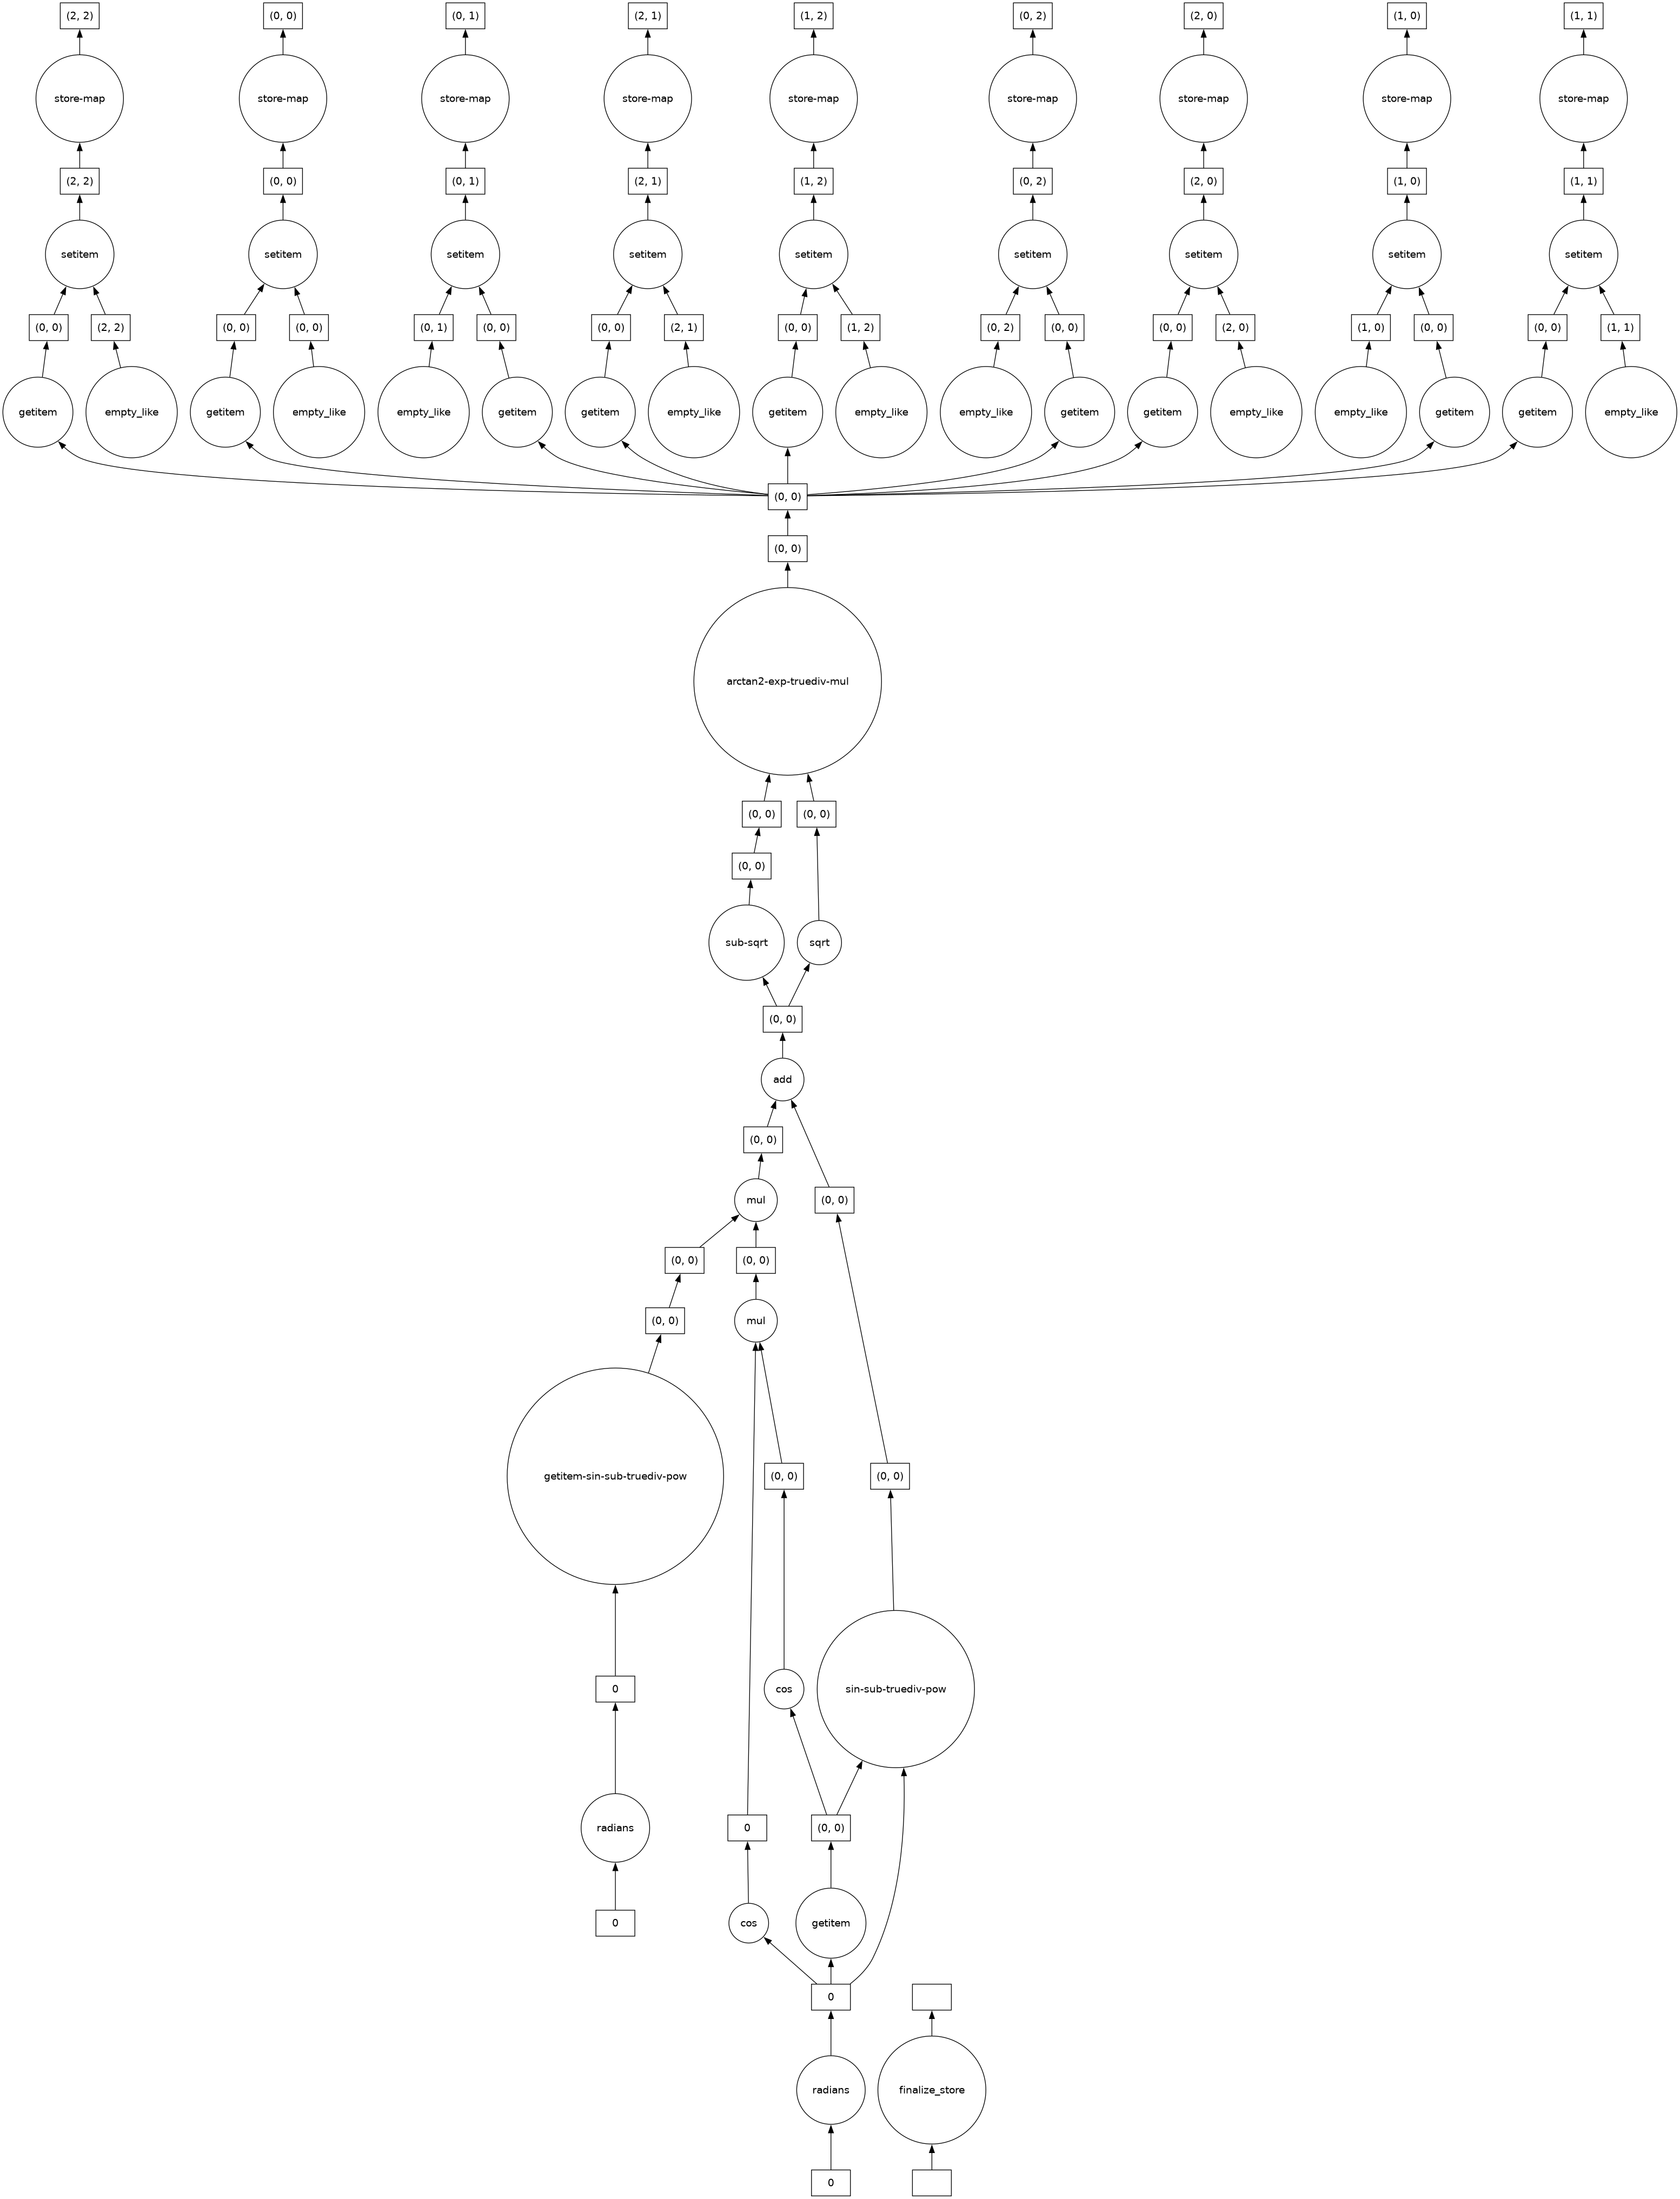

In [14]:
w.visualize()

In [33]:
w.compute()

2024-05-27 11:16:08,005 - distributed.worker - WARNING - Compute Failed
Key:       ('getitem-sin-sub-truediv-pow-815642dc16e1e88acf4290d5acc42714', 0, 0)
Function:  execute_task
args:      ((subgraph_callable-a9aa650e-9d60-4de9-b4e9-2339379462a5, (subgraph_callable-abd35a17-41ab-4e13-9b02-531f8d1a7706, (subgraph_callable-a550c0c8-c609-400e-9af2-6f85c7e7d24e, (subgraph_callable-e164ece3-663c-483a-97fe-30ae0dd40e61, (<function getitem at 0x7feda45b9630>, array([-0.16929694, -0.16755161, -0.16580628, ...,  0.32986723,
        0.33161256,  0.33335789]), (slice(None, None, None), None)), array([-0.16929694, -0.16755161, -0.16580628, ...,  0.32986723,
        0.33161256,  0.33335789])), 2.0)), 2))
kwargs:    {}
Exception: "MemoryError((121506, 121506), dtype('float64'))"

2024-05-27 11:16:08,006 - distributed.worker - WARNING - Compute Failed
Key:       ('sin-sub-truediv-pow-eeaf8f6917ed8280416a259ce373f1d0', 0, 0)
Function:  execute_task
args:      ((subgraph_callable-a277248a-0e77-44fa-a58

MemoryError: Unable to allocate 110. GiB for an array with shape (121506, 121506) and data type float64

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.105027 to fit


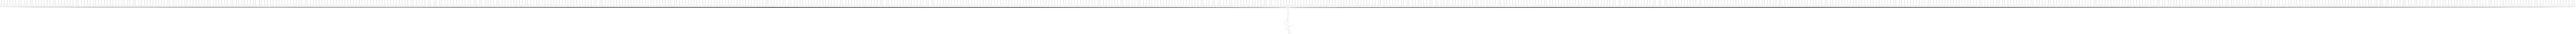

In [31]:
w.visualize()

In [ ]:
w.visualize(optimize_graph=True)

In [32]:
covv.dask

HighLevelGraph with 2 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7fc28fbb1570>
 0. empty_like-3df46cb98a6c94ff96d2b5c18e5692b6
 1. setitem-582dfe11ac642a66a42c1b93796457f4

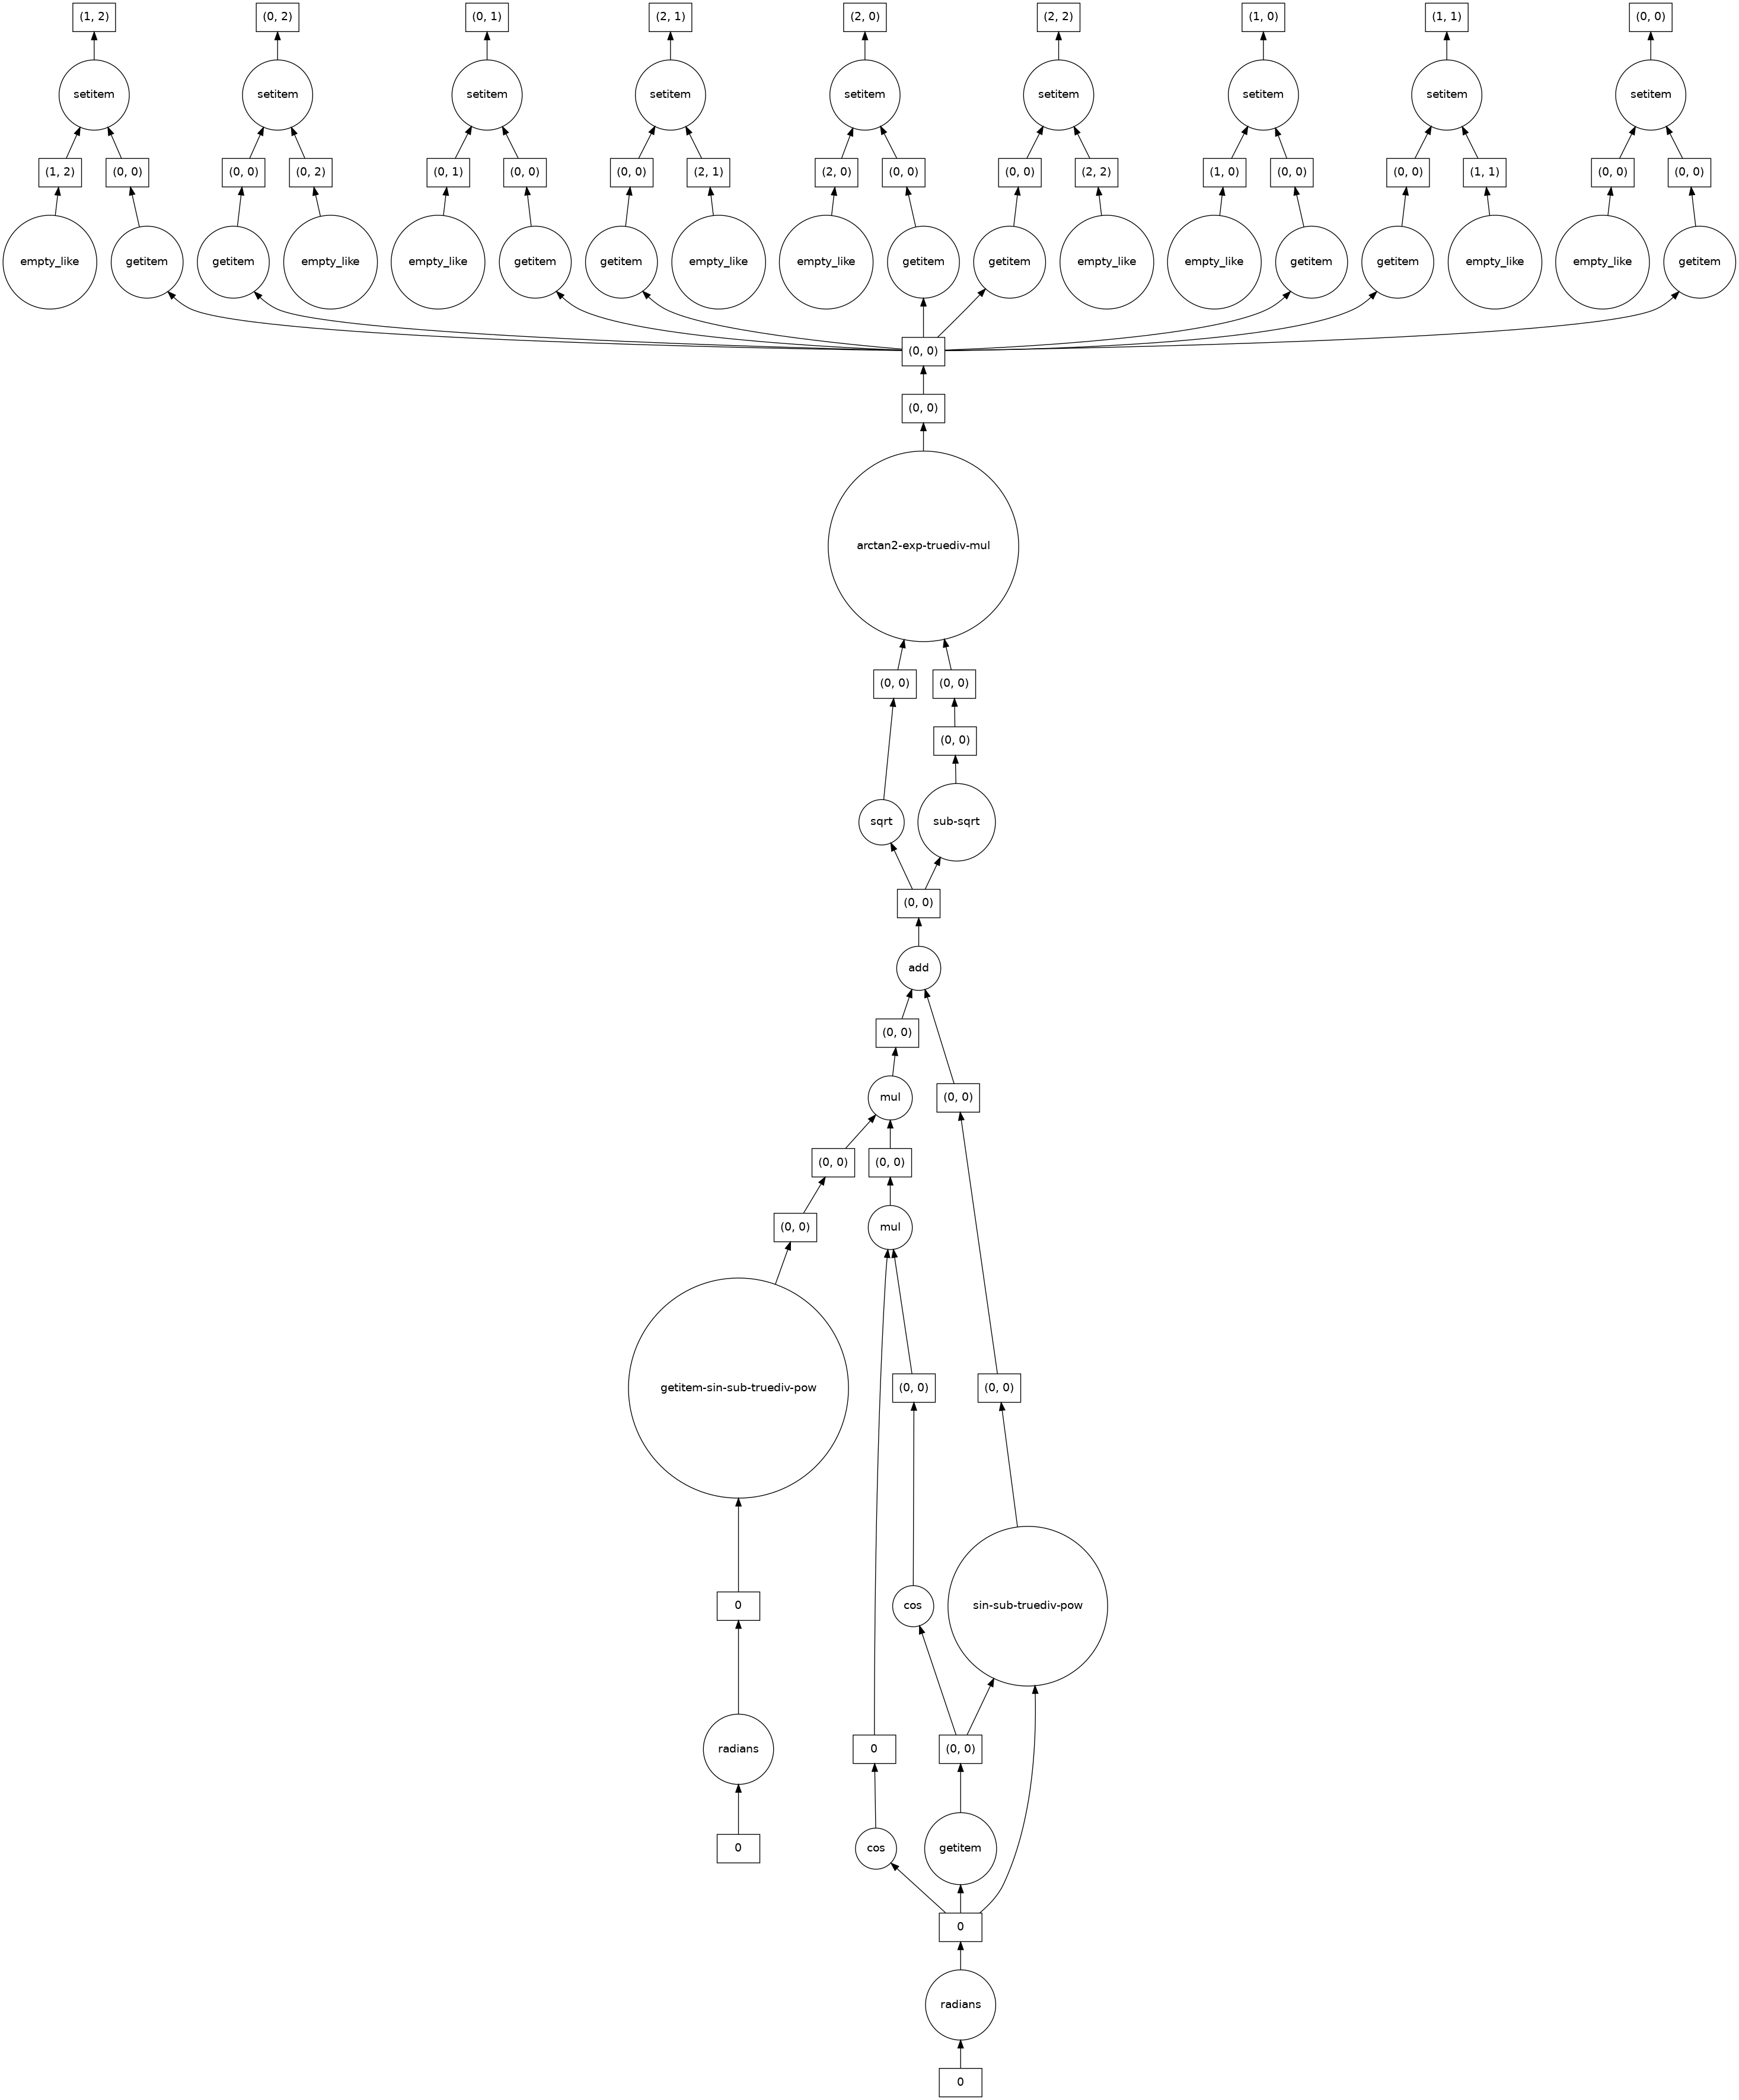

In [29]:
covv.visualize(optimize_graph = True)

In [22]:
latv

dask.array<array, shape=(11678,), dtype=float64, chunksize=(11678,), chunktype=numpy.ndarray>

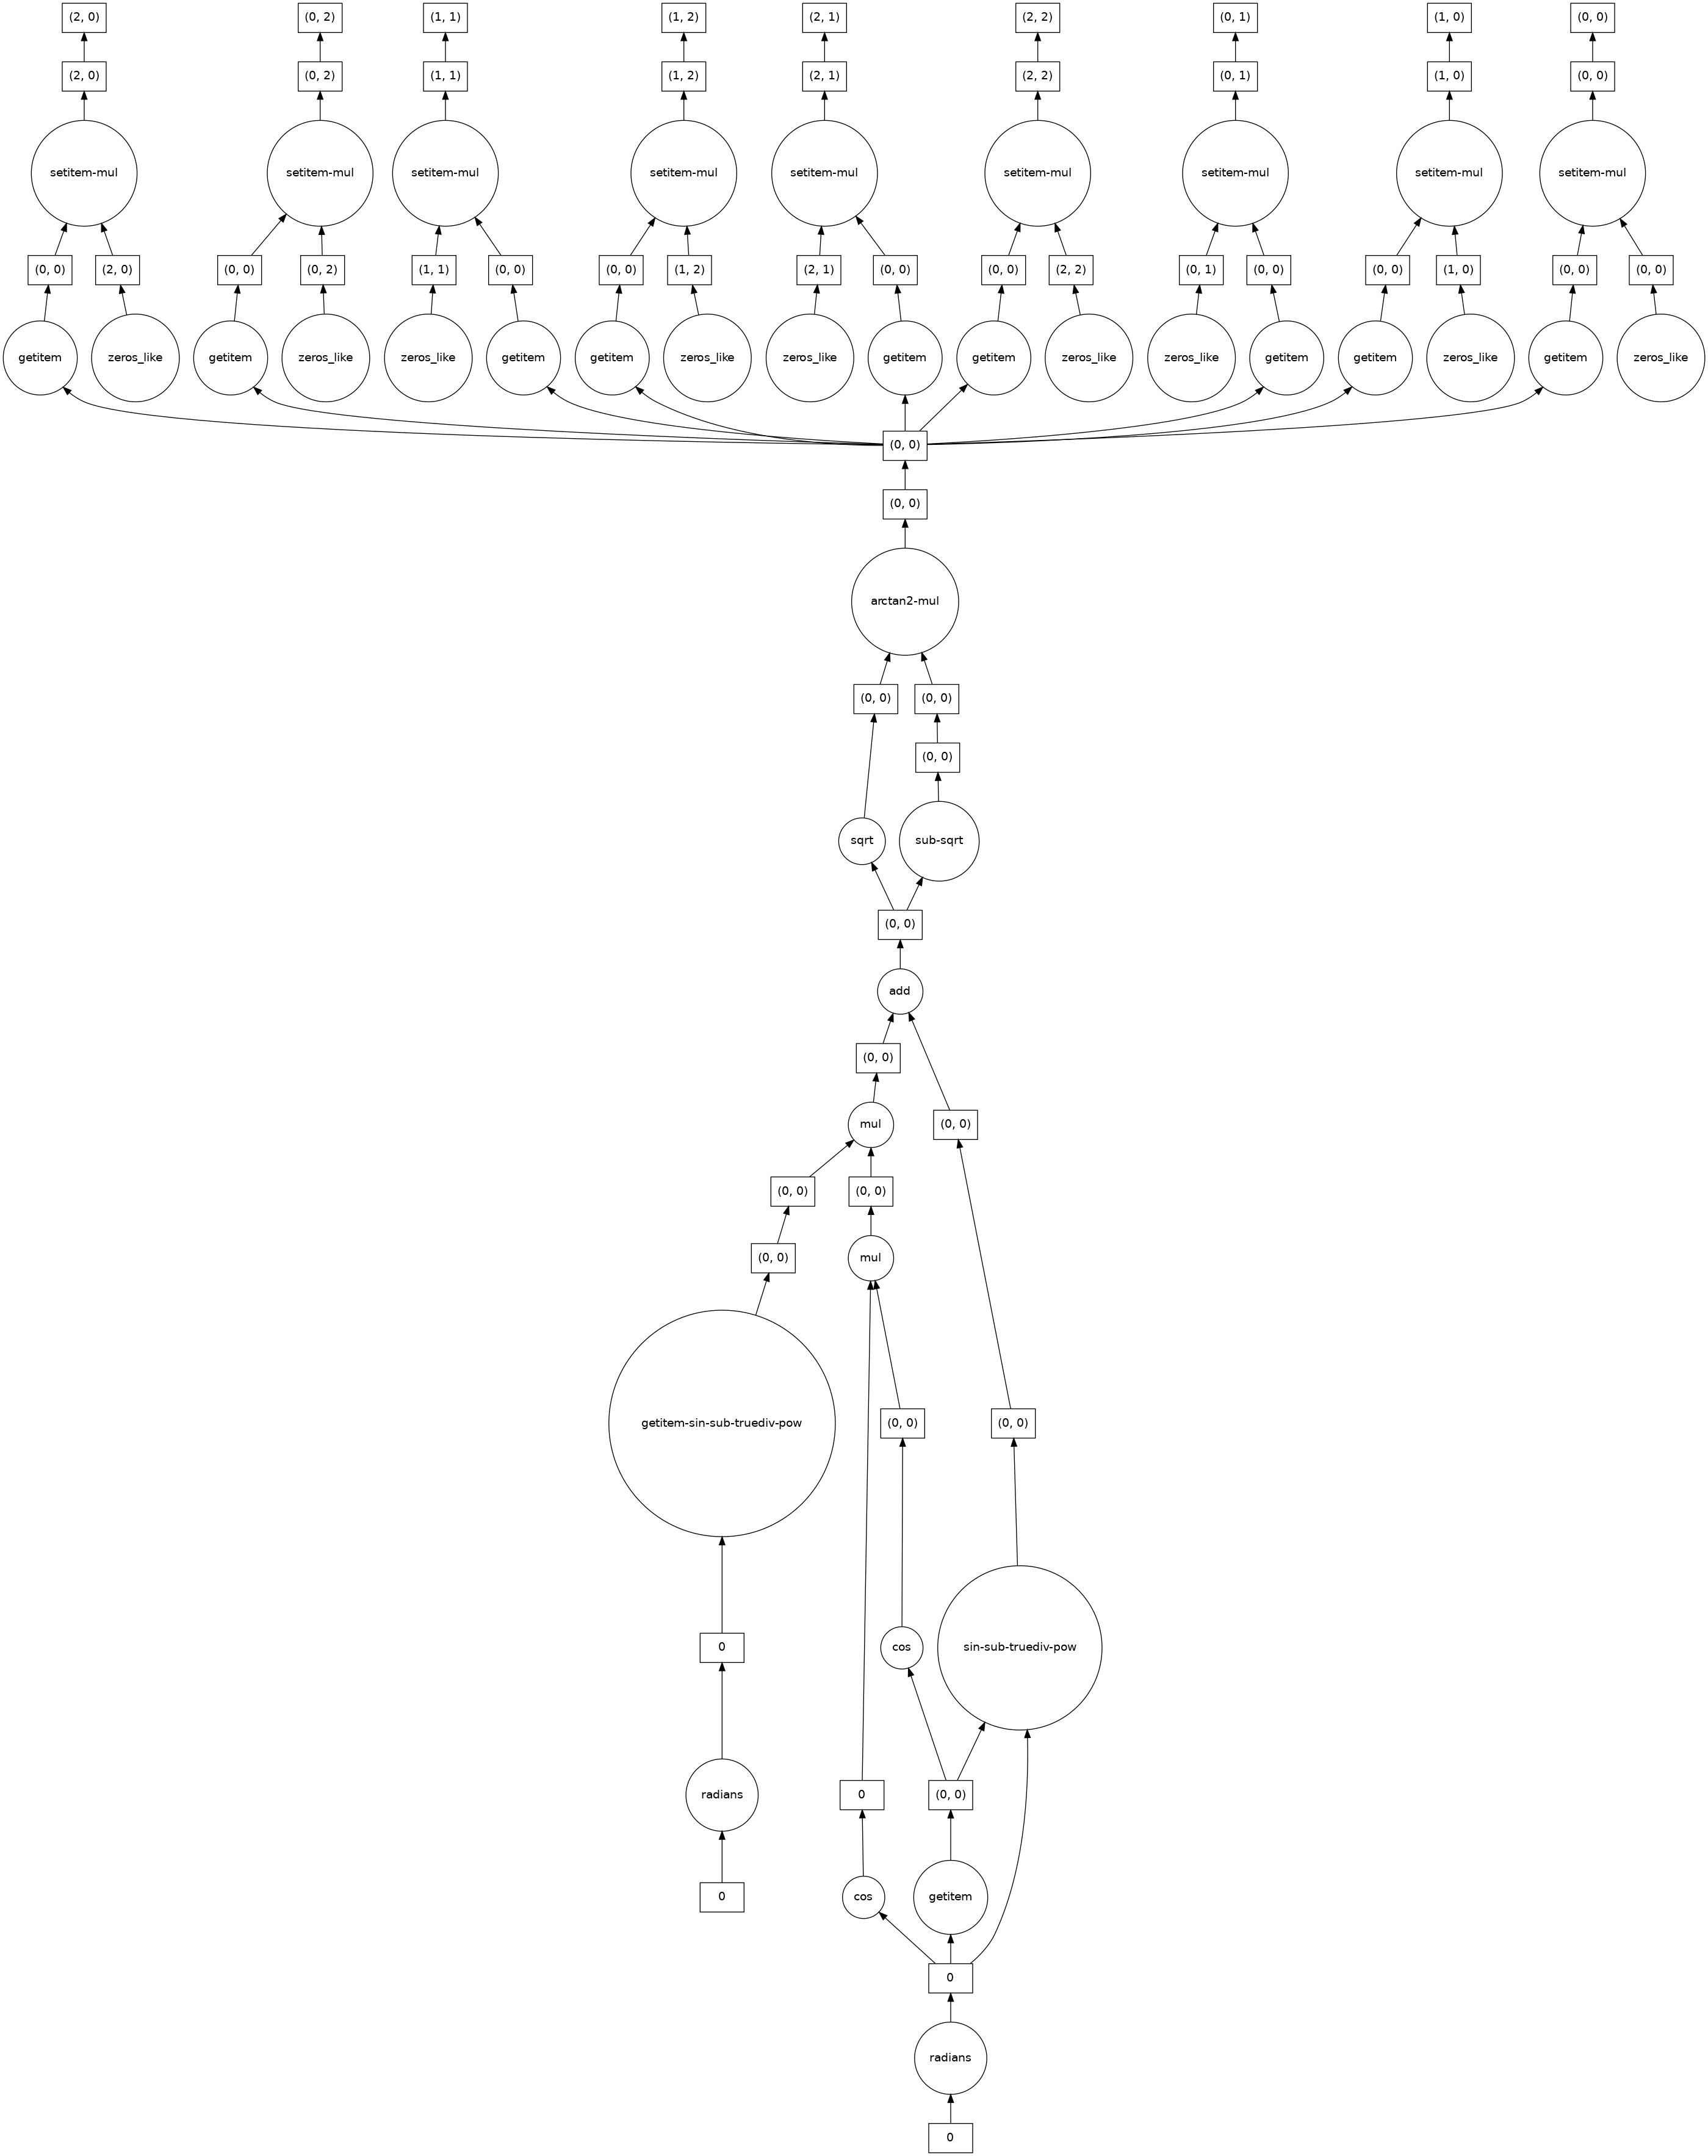

In [30]:
covv.visualize( optimize_graph=True)

# Compare to implementation where chunks given via latv, lonv and no initializing dists

In [27]:
latv2 = latgrid[lsm].flatten()
lonv2 = longrid[lsm].flatten() 

latv2 = da.from_array(latv2, chunks=4096)
lonv2 = da.from_array(lonv2, chunks=4096)
dists2 = haversine_distance(latv2, lonv2)
covv2 = sigma**2*da.exp(-1*dists2/l)

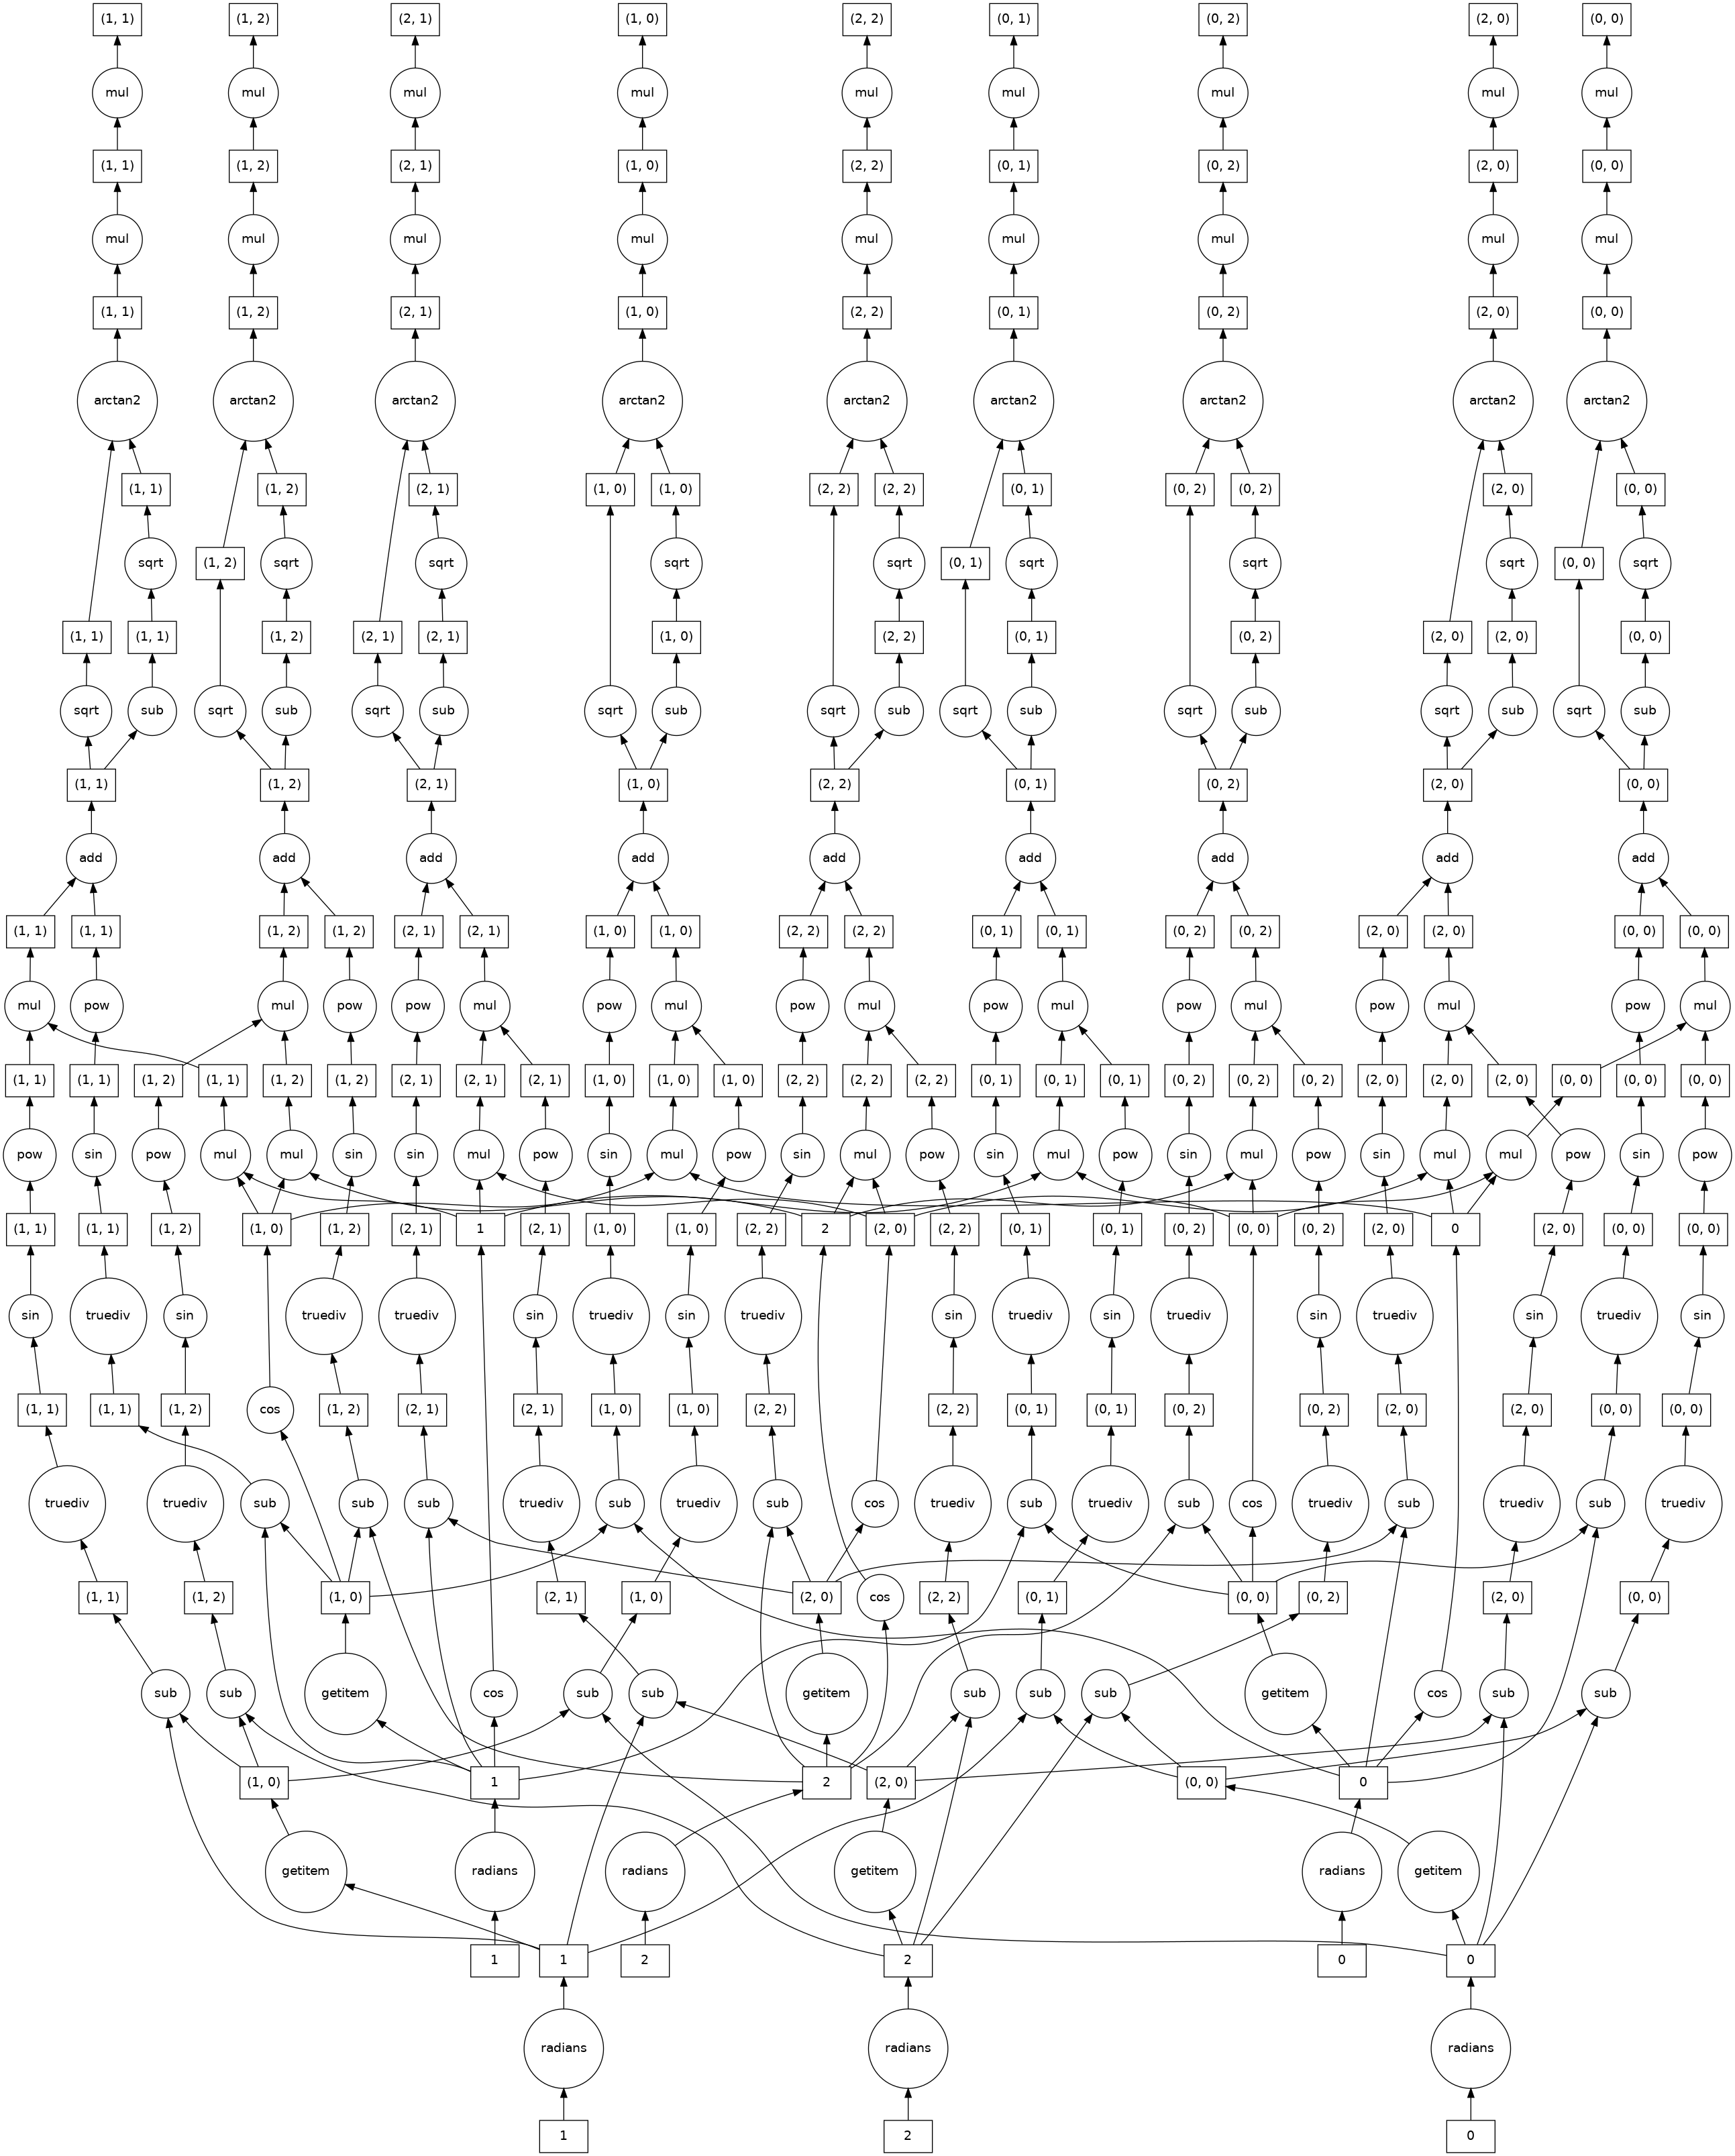

In [28]:
dists2.visualize()

In [29]:
dists2

dask.array<mul, shape=(11678, 11678), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [31]:
ds = create_dataset(covv, latv, lonv, v)
today = datetime.now()
OUTPUT_PATH = '/home/pietaril/Documents/data/unc_cov_matrices'
fname = f'CO2_prior_cov_eur_{v}_{today.strftime("%d%m%Y")}.nc'
ds.to_netcdf(os.path.join(OUTPUT_PATH, fname))

Try the two for-loops version of making the cov matrix with dask
* i.e. version that Aki & Maria use

In [20]:
cov, lat, lon = compute_cov_separately(lsm, latgrid, longrid, sigmas, L, "land").compute()

In [14]:
client.shutdown()

2024-05-30 11:25:12,072 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
